In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import thal1
from cgl_thalamic import rhs_thal

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

In [2]:
reload(thal1);reload(nm);reload(rp)
nmc = nm.nmCoupling;rsp = rp.Response

# Forcing function

In [3]:
def ff(x,a,om,del1=0):
    return a*np.sin((om+del1)*x)+.2

# Thalamic 1

In [4]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'om':1,'om_fix':1}

pd2 = {'om':1,'amp':1,'om_fix':1,'esyn':-1,'c':1}

In [5]:
system1 = rsp(var_names=['v','h','r','qt'],
              pardict=pd1,rhs=rhs_thal,
              init=np.array([-.64,0.71,0.25,0,5]),
              TN=2000,
              idx=0,
              model_name='thalf0',
              
              #recompute_list=['g','z','i'],
              z_forward=False,
              i_forward=False,
              i_bad_dx=False,
              coupling=thal1.coupling_thal)

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.023568265867307696
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [6]:
# default period must be 2*np.pi
system2 = rsp(var_names=[],
              pardict=pd2,rhs=None,init=None,
              coupling=None,
              model_name='thal_force1',
              forcing_fn=ff,
              idx=1,
              TN=0)

In [7]:
a = nmc(system1,system2,
       recompute_list=['p_data_thalf0','h_data_thalf0'],
       _n=('om0',1),_m=('om1',1),
       NP=500,NH=500)

* Loading p symbolic...
* Computing p...
* Computing p...
* Computing p...
* Loading H symbolic...
* Computing H thalf0, order=0...
* Computing H thalf0, order=1...
* Computing H thalf0, order=2...


In [8]:
print(system1.K['sym'])
print(system1.p['sym'])
print(system1.h['sym'])

{'v0': [esyn0*f1*om0*om_fix0/c0 - f1*om0*om_fix0*v0/c0, -f1*om0*om_fix0*g_thalf0_v0[1]*p_thalf0[1]/c0, -f1*om0*om_fix0*g_thalf0_v0[1]*p_thalf0[2]/c0 - f1*om0*om_fix0*g_thalf0_v0[2]*p_thalf0[1]**2/c0], 'h0': [0, 0, 0], 'r0': [0, 0, 0], 'qt0': [0, 0, 0]}
{0: 0, 1: esyn0*f1*om0*om_fix0*i_thalf0_v0[0]/c0 - f1*om0*om_fix0*v0*i_thalf0_v0[0]/c0, 2: esyn0*f1*om0*om_fix0*i_thalf0_v0[1]*p_thalf0[1]/c0 - f1*om0*om_fix0*v0*i_thalf0_v0[1]*p_thalf0[1]/c0 - f1*om0*om_fix0*g_thalf0_v0[1]*i_thalf0_v0[0]*p_thalf0[1]/c0}
{0: esyn0*f1*om0*om_fix0*z_thalf0_v0[0]/c0 - f1*om0*om_fix0*v0*z_thalf0_v0[0]/c0, 1: esyn0*f1*om0*om_fix0*p_thalf0[1]*z_thalf0_v0[1]/c0 - f1*om0*om_fix0*v0*p_thalf0[1]*z_thalf0_v0[1]/c0 - f1*om0*om_fix0*g_thalf0_v0[1]*p_thalf0[1]*z_thalf0_v0[0]/c0, 2: esyn0*f1*om0*om_fix0*p_thalf0[1]**2*z_thalf0_v0[2]/c0 + esyn0*f1*om0*om_fix0*p_thalf0[2]*z_thalf0_v0[1]/c0 - f1*om0*om_fix0*v0*p_thalf0[1]**2*z_thalf0_v0[2]/c0 - f1*om0*om_fix0*v0*p_thalf0[2]*z_thalf0_v0[1]/c0 - f1*om0*om_fix0*g_thalf0_v0[1

## Reduced rhs

In [9]:
def thal_redu(t,y,eps,system1):
    h = 0
    for i in range(system1.miter):
        h += eps**(i+1)*(system1.h['lam'][i](y))

    return h

## Plot reduced RHS

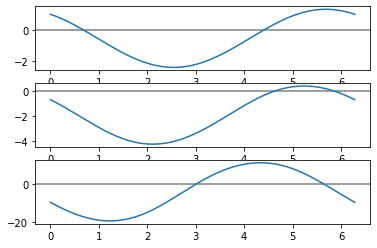

In [10]:
fig,axs = plt.subplots(3,1)

x = np.linspace(0,2*np.pi,200)
for i in range(3):
    axs[i].axhline(0,0,2*np.pi*a._m[1],color='gray')
    axs[i].plot(x,system1.h['lam'][i](x))

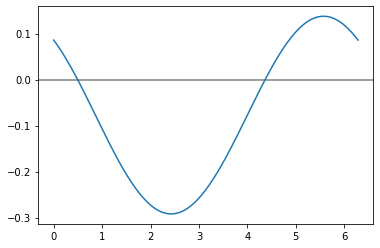

In [11]:
eps = .1
x = np.linspace(0,2*np.pi,1000)
h = thal_redu(0,x,eps,system1)
    
fig,axs = plt.subplots()
axs.axhline(0,0,2*np.pi,color='gray')
axs.plot(x,h)

## Full rhs

In [12]:
def thal_full(t,y,eps,pd1,pd2):
    out1 = rhs_thal(t,y,pd1,'val',0) + eps*thal1.coupling_thal([*y,system2(t)],pd1,'val',0)
    return np.array(list(out1))

# Integrate full and reduced

In [13]:
th_init = 2

In [14]:
eps_val = .01
pd1 = system1.pardict;pd2 = system2.pardict
pd1['om0'] = a._n[1];pd2['om1'] = a._m[1]

dt = .02;T=5000
t = np.arange(0,T,dt)
sol_redu = solve_ivp(thal_redu,[0,t[-1]],[th_init],method='LSODA',t_eval=t,
                     args=(eps_val,system1),rtol=1e-7,atol=1e-7)

In [15]:
# get init from LC
y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]
sol_full = solve_ivp(thal_full,[0,t[-1]],y0,method='LSODA',
                     t_eval=t,args=(eps_val,pd1,pd2),rtol=1e-6,atol=1e-6)

(4899.9800000000005, 4999.9800000000005)

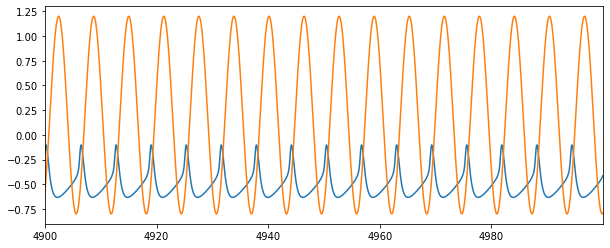

In [16]:
fig,axs = plt.subplots(figsize=(10,4))
axs.plot(sol_full.t,sol_full.y.T[:,0])
axs.plot(sol_full.t,system2(sol_full.t))
axs.set_xlim(t[-1]-100,t[-1])
#axs.set_xlim(0,100)

## Full model phase estimate

In [17]:
def get_phase(sol_full,skipn):

    phase1 = np.zeros(len(sol_full.t[::skipn]))
    for i in range(len(sol_full.t[::skipn])):
        d1 = np.linalg.norm(sol_full.y.T[::skipn][i,:4]-system1.lc['dat'],axis=1)
        phase1[i] = np.argmin(d1)/len(system1.lc['dat'])
    return sol_full.t[::skipn],phase1

In [18]:
# estimate phase for each model and compare phase difference
skipn = 10
x, phase1 = get_phase(sol_full,10)

# Full vs phase

(0.0, 6.283185307179586)

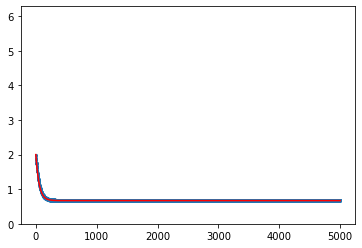

In [19]:
fig,axs = plt.subplots()
forcing_phase = np.mod(a._m[1]*np.linspace(0,x[-1],len(x)),2*np.pi)
y = np.mod(phase1*2*np.pi-a.om*forcing_phase,2*np.pi)
#y = phase1*2*np.pi

axs.scatter(x,y,s=1)
#axs.plot(x,np.mod(forcing_phase,2*np.pi))
axs.plot(t,np.mod(sol_redu.y.T[:,0],2*np.pi),color='red')
#axs.set_xlim(0,100)
axs.set_ylim(0,2*np.pi)

## Bifurcations in coupling strength

In [20]:
eps_list = np.linspace(0,.1,200)
x = np.linspace(0,2*np.pi,1000)
h = 0

zu = []
zs = []

for eps_val in eps_list:
    for i in range(system1.miter):
        h += eps_val**(i+1)*(system1.h['lam'][i](x))
    # get all zeros
    z1 = x[1:][(h[1:]>0)*(h[:-1]<=0)]
    z2 = x[1:][(h[1:]<0)*(h[:-1]>=0)]
    zu.append(z1)
    zs.append(z2)

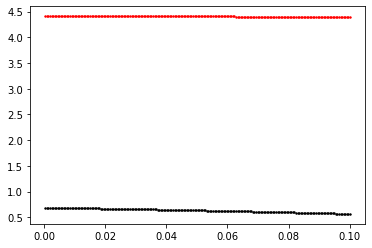

In [21]:
fig,axs=plt.subplots()

for xe, ye in zip(eps_list, zu):
    axs.scatter([xe] * len(ye), ye,s=2,c='red')

for xe, ye in zip(eps_list, zs):
    axs.scatter([xe] * len(ye), ye,s=2,c='k')

## Range of initial conditions

In [105]:
# thlist = np.linspace(0,2*np.pi,10,endpoint=False)
# epsval2 = .01

# dt2 = .02;T2=200
# t2 = np.arange(0,T2,dt2)

# fig,axs = plt.subplots()
# for th_val in thlist:
#     sol_full = solve_ivp(thal_full,[0,t2[-1]],y0,
#                          method='LSODA',t_eval=t2,args=(epsval2,pd1,pd2),
#                          rtol=1e-6,atol=1e-6)
#     x2,phases = get_phase(sol_full,20)

#     forcing_phase2 = np.mod(a._m[1]*np.linspace(0,x2[-1],len(x2)),2*np.pi)
#     #y2 = np.mod(phases*2*np.pi-a.om*forcing_phase2,2*np.pi)
#     #axs.plot(x2,forcing_phase2);axs.plot(x2,phases*2*np.pi)
#     axs.scatter(x2,np.mod(phases*2*np.pi-a.om*forcing_phase2,2*np.pi),s=5)
    